Install libraries

In [1]:
!pip install sentinelsat
!pip install geopandas
!pip install rasterio

Import libraries

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from sentinelsat import SentinelAPI
import folium
from shapely.geometry import MultiPolygon
from shapely.geometry import Polygon
from shapely.geometry import shape
from shapely.geometry import box
import urllib.request as request
import json
from datetime import datetime
import zipfile
import rasterio as rio
from rasterio.plot import show
import rasterio.mask
import os

Extract Geometries

In [0]:
max_records=10
first_record = 18290
current_record = first_record
names = []
countries = []
latitudes = []
longitudes = []
geometries = []
while len(names) < max_records:
  water_url = f'https://water.blue-dot-observatory.com/api/waterbodies/{current_record}/index.html'
  try:
    water_body_data = json.loads(request.urlopen(water_url).read().decode())
    names.append(water_body_data['properties']['name'])
    countries.append(water_body_data['properties']['country'])
    latitudes.append(water_body_data['properties']['lat'])
    longitudes.append(water_body_data['properties']['long'])
    geometries.append(water_body_data['nominal_outline']['geometry'])
  except:
    pass
  current_record += 1

Create Dataframe

In [0]:
water_bodies = pd.DataFrame({'Name':names,
                             'Country':countries,
                             'Latitude':latitudes,
                             'Longitude':longitudes,
                             'Geometry':geometries})

In [5]:
water_bodies

,Name,Country,Latitude,Longitude,Geometry
0,Lake Travis,United States of America,30.442056,-98.004388,"{'coordinates': [[[[-98.0217194, 30.3745221], ..."


Plot Map

In [0]:
my_map = folium.Map(location = [30.442056, -98.004388], zoom_start=11)

In [7]:
for water_body in water_bodies['Geometry']:
  folium.GeoJson(shape(water_body)).add_to(my_map)
my_map

Read login credentials

In [0]:
with open('/content/drive/My Drive/Sentinel Hub Credentials/login_info.txt') as file:
  credentials = file.readlines()
  credentials = [credential.strip() for credential in credentials]

Download Satellite Images

In [0]:
api = SentinelAPI(credentials[0], credentials[1], 'https://scihub.copernicus.eu/dhus')

In [0]:
today = datetime.today().strftime('%Y%m%d')

In [112]:
for water_body_geometry in water_bodies['Geometry']:

  water_body_shape = shape(water_body_geometry)
  shape_simplified = water_body_shape.simplify(0.01, preserve_topology=True)

  results = api.query(bbox, date = ('20140101', today), platformname = 'Sentinel-2', processinglevel = 'Level-2A', cloudcoverpercentage = (0,5))
  results_gdf = api.to_geodataframe(results).sort_values(['cloudcoverpercentage'], ascending=True)
  uuid = results_gdf.iloc[0]['uuid']
  filename = '/content/' + results_gdf.iloc[0]['title'] + '.zip'
  data = api.download(uuid)

  with zipfile.ZipFile(filename, 'r') as zip_ref:
    zip_ref.extractall('/content/drive/My Drive/Satellite Data/')
  folder = os.listdir('/content/drive/My Drive/Satellite Data/' + data['title'] + '.SAFE/GRANULE/')[0]
  resolution_10m = '/content/drive/My Drive/Satellite Data/' + data['title'] + '.SAFE/GRANULE/' + folder + '/IMG_DATA/R10m/'

Querying products: 100%|██████████| 144/144 [00:00<00:00, 191.48 products/s]
/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [113]:
folder

'L1C_T14RNU_A025277_20200424T171631'

In [114]:
for f in os.listdir(resolution_10m):
  if '_B02_' in f:
    band_2 = rio.open(resolution_10m + f)
  elif '_B03_' in f:
    band_3 = rio.open(resolution_10m + f)
  elif '_B04_' in f:
    band_4 = rio.open(resolution_10m + f)

FileNotFoundError: ignored

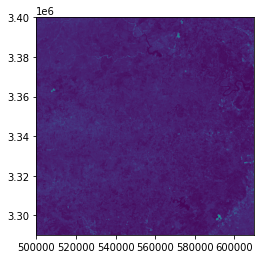

In [77]:
show(band_4)

In [0]:
bbox = box(minx=lake_travis.bounds[0], miny=lake_travis.bounds[1], maxx=lake_travis.bounds[2], maxy=lake_travis.bounds[3])

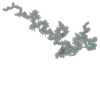

In [85]:
lake_travis

In [0]:
results = api.query(bbox, date = ('20140101', today), platformname = 'Sentinel-2', processinglevel = 'Level-2A', cloudcoverpercentage = (0,5))

In [117]:
results_gdf = api.to_geodataframe(results).sort_values(['cloudcoverpercentage'], ascending=True)

/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [121]:
results_gdf.iloc[0]['filename']

'S2B_MSIL2A_20191201T171649_N0213_R112_T14RNU_20191201T195554.SAFE'